In [1]:
import pandas as pd
import numpy as np

import pyterrier as pt
import os, datetime

from joblib import dump, load

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

SEED=42
RANDOM_STATE = 0



In [2]:
# !module load openjdk
# !echo $JAVA_HOME
# !export JAVA_HOME=/sw/pkgs/arc/openjdk/jdk-18.0.1.1

import socket
socket.getaddrinfo('localhost', 8080)
# os.environ["JAVA_HOME"] ='C:/Program Files/Java/jdk-18.0.1.1'
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



In [3]:
emotion_map = {'sadness':0, 'joy':1, 'love':2, 'anger':3,'fear':4,'surprise':5, 0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
emotions = ['sadness', 'joy', 'love', 'anger','fear','surprise']

In [4]:
docs_df = pd.DataFrame(load('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/merged_training.pkl')).reset_index(drop=True)
docs_df.columns = ['text','label']
docs_df['emotion'] = docs_df['label']
docs_df['label'] = docs_df['label'].replace(emotion_map)
docs_df['docno'] = [str(a) for a in range(docs_df.shape[0])]
docs_df



,text,label,emotion,docno
0,i feel awful about it too because it s my job ...,0,sadness,0
1,im alone i feel awful,0,sadness,1
2,ive probably mentioned this before but i reall...,1,joy,2
3,i was feeling a little low few days back,0,sadness,3
4,i beleive that i am much more sensitive to oth...,2,love,4
...,...,...,...,...
416804,that was what i felt when i was finally accept...,1,joy,416804
416805,i take every day as it comes i m just focussin...,4,fear,416805
416806,i just suddenly feel that everything was fake,0,sadness,416806
416807,im feeling more eager than ever to claw back w...,1,joy,416807


In [5]:
from textblob import TextBlob
import nltk
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

def sentiment_textblob(row):
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    subjectivity = classifier.sentiment.subjectivity
    return polarity,subjectivity

In [6]:
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl'):
    docs_df['tok'] = [word_tokenize(a) for a in docs_df.text]
    docs_df['tok'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl')
else:
    docs_df['tok'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/tok.pkl')
# docs_df

In [7]:
# only used for counting emotions
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl'):
    docs_df['stem'] = [[stemmer.stem(b) for b in a] for a in docs_df.tok]
    docs_df['stem'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl')
else:
    docs_df['stem'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/stem.pkl')
# docs_df

# may require downloading nltk packages
emotion_synonyms, emotion_antonyms = dict(), dict()
# for i in pd.unique(docs_df['query']):
for i in pd.unique(docs_df['emotion']):
    emotion_synonyms[i], emotion_antonyms[i] = set(), set()
    for syn in wordnet.synsets(i):
        for l in syn.lemmas():
            if '_' not in l.name():
                emotion_synonyms[i].add(l.name())
            if l.antonyms() and '_' not in l.antonyms()[0].name():
                emotion_antonyms[i].add(l.antonyms()[0].name())
emotion_terms_all = {stemmer.stem(i) for a in emotion_synonyms for i in emotion_synonyms[a] }.union({stemmer.stem(i) for a in emotion_antonyms for i in emotion_antonyms[a] })
# emotion_terms_all

In [8]:
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl'):
    docs_df['pos_tup'] = [nltk.tag.pos_tag(a) for a in docs_df.tok]
    docs_df['pos_tup'].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl')
else:
    docs_df['pos_tup'] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/pos_tup.pkl')
    
docs_df['pos'] = [[b[1] for b in a] for a in docs_df.pos_tup]
# docs_df

In [9]:

if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl'):
    docs_df[['polarity', 'subjectivity']] = pd.DataFrame([sentiment_textblob(a) for a in docs_df.text], columns=['polarity', 'subjectivity'])
    docs_df[['polarity', 'subjectivity']].to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl')
else:
    docs_df[['polarity', 'subjectivity']] = pd.read_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/polarity_subjectivity.pkl')
# docs_df.dtypes

In [10]:
docs_df.head()

,text,label,emotion,docno,tok,stem,pos_tup,pos,polarity,subjectivity
0,i feel awful about it too because it s my job ...,0,sadness,0,"[i, feel, awful, about, it, too, because, it, ...","[i, feel, aw, about, it, too, becaus, it, s, m...","[(i, NN), (feel, VBP), (awful, JJ), (about, IN...","[NN, VBP, JJ, IN, PRP, RB, IN, PRP, VBD, PRP$,...",-1.000000,1.000000
1,im alone i feel awful,0,sadness,1,"[im, alone, i, feel, awful]","[im, alon, i, feel, aw]","[(im, NN), (alone, RB), (i, JJ), (feel, VBP), ...","[NN, RB, JJ, VBP, JJ]",-1.000000,1.000000
2,ive probably mentioned this before but i reall...,1,joy,2,"[ive, probably, mentioned, this, before, but, ...","[ive, probabl, mention, thi, befor, but, i, re...","[(ive, NN), (probably, RB), (mentioned, VBD), ...","[NN, RB, VBD, DT, IN, CC, VBP, RB, VBP, VB, NN...",0.284091,0.438636
3,i was feeling a little low few days back,0,sadness,3,"[i, was, feeling, a, little, low, few, days, b...","[i, wa, feel, a, littl, low, few, day, back]","[(i, NN), (was, VBD), (feeling, VBG), (a, DT),...","[NN, VBD, VBG, DT, JJ, JJ, JJ, NNS, RB]",-0.096875,0.225000
4,i beleive that i am much more sensitive to oth...,2,love,4,"[i, beleive, that, i, am, much, more, sensitiv...","[i, beleiv, that, i, am, much, more, sensit, t...","[(i, JJ), (beleive, VBP), (that, IN), (i, NN),...","[JJ, VBP, IN, NN, VBP, RB, RBR, JJ, TO, JJ, NN...",0.243750,0.568750


- paper involving using ratios of specific pos in model https://ieeexplore.ieee.org/abstract/document/8625499
- official pos tags used in nltk https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
- pos tag descriptions https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
- negative contractions https://www.thoughtco.com/what-is-a-negative-contraction-1691339

- replace MD's
- noun: contains NN
- pronoun: countians PR
- verb: contains VB
- adverb: contains RB
- modal auxiliary: MD
- adjective: contains JJ
- causal conjunction: IN

In [11]:
# docno
pos_pref = ['NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN']
pos_list = list(docs_df.pos.explode().unique())
# pos_list

for pref in pos_pref:
    tags = {a for a in pos_list if pref in a}
    docs_df[pref] = [sum(1 for tag in row if tag in tags) for row in docs_df.pos]
    
docs_df['pos_sum'] = docs_df[pos_pref].sum(axis=1)
docs_df[pos_pref] = docs_df[pos_pref].div(docs_df['pos_sum'], axis=0)


# calculate ratio of emotion terms among stem
docs_df['er'] = [sum(1 for tag in row if tag in emotion_terms_all) for row in docs_df.stem] / docs_df['pos_sum']

# calculate ratio of negatives
negations = {'no','not','arent', 'isnt', 'wasnt', 'werent', 'cant', 'couldnt', 'mustnt', 'shouldnt', 'wont', 'wouldnt', 'didnt', 'doesnt', 'dont', 'hasnt', 'havent', 'hadnt'}
docs_df['neg'] = [sum(1 for tag in row if tag in negations) for row in docs_df.tok] / docs_df['pos_sum']

In [12]:
docs_df.columns

Index(['text', 'label', 'emotion', 'docno', 'tok', 'stem', 'pos_tup', 'pos',
       'polarity', 'subjectivity', 'NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN',
       'pos_sum', 'er', 'neg'],
      dtype='object')

In [13]:
if not os.path.exists('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/docs_df.pkl'):
    docs_df.to_pickle('emotion/datasets/Emotion Dataset for Emotion Recognition Tasks/docs_df.pkl')

In [14]:
numeric_columns = ["polarity", "subjectivity", "er", "neg"] + pos_pref
print(numeric_columns)

index_dir = os.path.join(os.getcwd(),'indices','carer7') #####

# https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html#dfindexer
if not os.path.exists(os.path.join(index_dir, "data.properties")):
    indexer = pt.DFIndexer(index_dir, overwrite=True)
    indexer.setProperty("termpipelines", "")
    index_ref = indexer.index(docs_df["text"].astype('string'), docs_df[["docno", 'emotion'] + numeric_columns].astype('string')) # 7
    
else:
    index_ref = pt.IndexRef.of(os.path.join(index_dir, "data.properties"))
index = pt.IndexFactory.of(index_ref)

['polarity', 'subjectivity', 'er', 'neg', 'NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN']


In [15]:
print(index.getCollectionStatistics().toString())

Number of documents: 416809
Number of terms: 74675
Number of postings: 7081934
Number of fields: 0
Number of tokens: 8006231
Field names: []
Positions:   false



In [16]:
docs_df.head()

,text,label,emotion,docno,tok,stem,pos_tup,pos,polarity,subjectivity,NN,PR,VB,RB,MD,JJ,IN,pos_sum,er,neg
0,i feel awful about it too because it s my job ...,0,sadness,0,"[i, feel, awful, about, it, too, because, it, ...","[i, feel, aw, about, it, too, becaus, it, s, m...","[(i, NN), (feel, VBP), (awful, JJ), (about, IN...","[NN, VBP, JJ, IN, PRP, RB, IN, PRP, VBD, PRP$,...",-1.000000,1.000000,0.181818,0.227273,0.227273,0.136364,0.0,0.090909,0.136364,22,0.0,0.0
1,im alone i feel awful,0,sadness,1,"[im, alone, i, feel, awful]","[im, alon, i, feel, aw]","[(im, NN), (alone, RB), (i, JJ), (feel, VBP), ...","[NN, RB, JJ, VBP, JJ]",-1.000000,1.000000,0.200000,0.000000,0.200000,0.200000,0.0,0.400000,0.000000,5,0.0,0.0
2,ive probably mentioned this before but i reall...,1,joy,2,"[ive, probably, mentioned, this, before, but, ...","[ive, probabl, mention, thi, befor, but, i, re...","[(ive, NN), (probably, RB), (mentioned, VBD), ...","[NN, RB, VBD, DT, IN, CC, VBP, RB, VBP, VB, NN...",0.284091,0.438636,0.260870,0.043478,0.217391,0.130435,0.0,0.130435,0.217391,23,0.0,0.0
3,i was feeling a little low few days back,0,sadness,3,"[i, was, feeling, a, little, low, few, days, b...","[i, wa, feel, a, littl, low, few, day, back]","[(i, NN), (was, VBD), (feeling, VBG), (a, DT),...","[NN, VBD, VBG, DT, JJ, JJ, JJ, NNS, RB]",-0.096875,0.225000,0.250000,0.000000,0.250000,0.125000,0.0,0.375000,0.000000,8,0.0,0.0
4,i beleive that i am much more sensitive to oth...,2,love,4,"[i, beleive, that, i, am, much, more, sensitiv...","[i, beleiv, that, i, am, much, more, sensit, t...","[(i, JJ), (beleive, VBP), (that, IN), (i, NN),...","[JJ, VBP, IN, NN, VBP, RB, RBR, JJ, TO, JJ, NN...",0.243750,0.568750,0.266667,0.000000,0.266667,0.133333,0.0,0.266667,0.066667,15,0.0,0.0


In [17]:
topics = docs_df[['emotion']].drop_duplicates(ignore_index=True).rename(columns={'emotion':'query'})
topics['qid'] = [str(a) for a in range(topics.shape[0])]
topics

,query,qid
0,sadness,0
1,joy,1
2,love,2
3,anger,3
4,fear,4
5,surprise,5


In [18]:
qrels = docs_df.merge(topics, left_on='emotion', right_on='query', how='inner')[['qid','docno','label']]
qrels.columns = ['qid','docno','label']
qrels

,qid,docno,label
0,0,0,0
1,0,1,0
2,0,3,0
3,0,11,0
4,0,16,0
...,...,...,...
416804,5,416708,5
416805,5,416712,5
416806,5,416738,5
416807,5,416755,5


### custom experiment function for different emotions and ndcg cutoffs

"Relevant" docs are scored a 3 if they match the emotion, and 0 otherwise

In [19]:
def dcg_list(scores):
    # assuming increasing index
    res = []
    for i in range(len(scores)):
        res.append(scores[i]/np.log2(i+2))
    return sum(np.nan_to_num(res))

def ndcg_of_emotion(searchresults, emotion, cutoff=None):
    if searchresults.empty:
        return 0
    
    if cutoff is None:
        df = pd.DataFrame(searchresults)
    else:
        df = pd.DataFrame(searchresults.head(cutoff))
    scores = []
    for i in df.itertuples():
        if i.emotion != emotion:
            scores.append(0)
        else:
            scores.append(3)
    dcg = dcg_list(scores)
    idcg = dcg_list(sorted(scores, reverse=True))
    ret = dcg/idcg
    return ret


def ndcg_per_emotion_experiment(models, names, emotions, qrels, docs_df, cutoffs=[None]):
    test_docs = qrels.merge(docs_df[['docno','emotion','text']], on='docno')
    res = pd.DataFrame()
    
    for i in range(len(models)):
        model_res = pd.DataFrame()
        model_res['name'] = [names[i]]
        for emotion in emotions:
            scores = dict()
            for doc in test_docs.loc[test_docs.emotion == emotion,:].itertuples():
                searchresults = models[i].search(doc.text)
                for cutoff in cutoffs:
                    if cutoff not in scores:
                        scores[cutoff] = []
                        
                    scores[cutoff].append(ndcg_of_emotion(searchresults, emotion, cutoff))
                    
            for cutoff in cutoffs:
                if cutoff is None:
                    model_res[emotion+'_ndcg'] = [np.mean(np.nan_to_num(scores[cutoff]))]
                else:
                    model_res[emotion+'_ndcg_cut_'+str(cutoff)] = [np.mean(np.nan_to_num(scores[cutoff]))]
        
        model_res = model_res.set_index('name').reset_index()
        res = pd.concat([res,model_res], axis=0)
    res2 = res[['name']] # group emotions by cutoff
    for cutoff in cutoffs:
        if cutoff is not None:
            cutoff_ = 'ndcg_cut_'+str(cutoff)
        else:
            cutoff_ = 'ndcg'
        res2 = pd.concat([res2, res[[a for a in res.columns if a.endswith(cutoff_)]]], axis=1)
    return res2


In [20]:
num_queries_per_emotion = 100


test_qrels = pd.DataFrame()
for label in pd.unique(qrels.label):
    test_qrels = pd.concat([test_qrels, qrels.loc[qrels.label == label,:].sample(num_queries_per_emotion, random_state=0)], axis=0)
# test_qrels

tr_va_qrels = qrels.drop(test_qrels.index)
# tr_va_qrels

# tr_va_qrels, test_qrels = train_test_split(qrels, test_size=1/10, random_state=SEED)
train_qrels, valid_qrels =  train_test_split(tr_va_qrels, test_size=2/10, random_state=SEED)

print(train_qrels.shape)
print(valid_qrels.shape)
print(test_qrels.shape)

(332967, 3)
(83242, 3)
(600, 3)


In [21]:
metadata = ['docno', 'emotion', 'polarity', 'subjectivity', 'er', 'neg', 'NN', 'PR', 'VB', 'RB', 'MD', 'JJ', 'IN']


termpipelines = "PorterStemmer"


tf = pt.BatchRetrieve(index, metadata=metadata, wmodel="Tf", properties={"termpipelines" : termpipelines})
tfidf = pt.BatchRetrieve(index, metadata=metadata, wmodel="TF_IDF", properties={"termpipelines" : termpipelines})
bm25 = pt.BatchRetrieve(index, metadata=metadata, wmodel="BM25", properties={"termpipelines" : termpipelines})


In [22]:
ltr_feats1 = bm25 >> (
    pt.transformer.IdentityTransformer()
    ** 
    pt.FeaturesBatchRetrieve(index, wmodel="TF_IDF", features=["WMODEL:DirichletLM"], properties={"termpipelines" : ""})

    **
    pt.apply.doc_features(lambda row: np.array([float(row[a]) for a in numeric_columns]))
    
) 
fnames=["BM25", "TF_IDF-DirichletLM"]  + numeric_columns
# fnames=["BM25", "TF_IDF-DirichletLM", 'BM25_nouns_removed'] + numeric_columns
ltr_feats1 

ComposedPipeline(BR(c:\Users\alexw\OneDrive\College Files 2022-2024\Fall 2022\650 Information Retrieval\project\indices\carer7/data.properties,{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'wmodel': 'BM25'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.controls': 'wmodel:DPH,parsecontrols:on,parseql:on,applypipeline:on,terrierql:on,localmatching:on,filters:on,decorate:on', 'querying.allowed.controls': 'scope,qe,qemodel,start,end,

In [23]:
# ltr_feats1.search('i feel terrible today').head(20)

## Build models to test

In [24]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rf = RandomForestRegressor(n_estimators=400, verbose=0, random_state=SEED, n_jobs=5)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(topics, train_qrels)

CPU times: total: 14.1 s
Wall time: 3.69 s


In [25]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=400, verbose=0, random_state=SEED, n_jobs=5)

rfc_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rfc)

%time rfc_pipe.fit(topics, train_qrels)

CPU times: total: 5.36 s
Wall time: 2.12 s


In [26]:
import fastrank
train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(topics, train_qrels)

CPU times: total: 6.72 s
Wall time: 2.33 s


In [27]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    verbosity=0,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[20],
    ndcg_at=[20],
    eval_at=[20],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5,
    
    random_state=SEED
    # ,
    # n_jobs=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[20]})

%time lmart_x_pipe.fit(topics, train_qrels, topics, valid_qrels)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGB

## inspect models - feature importances

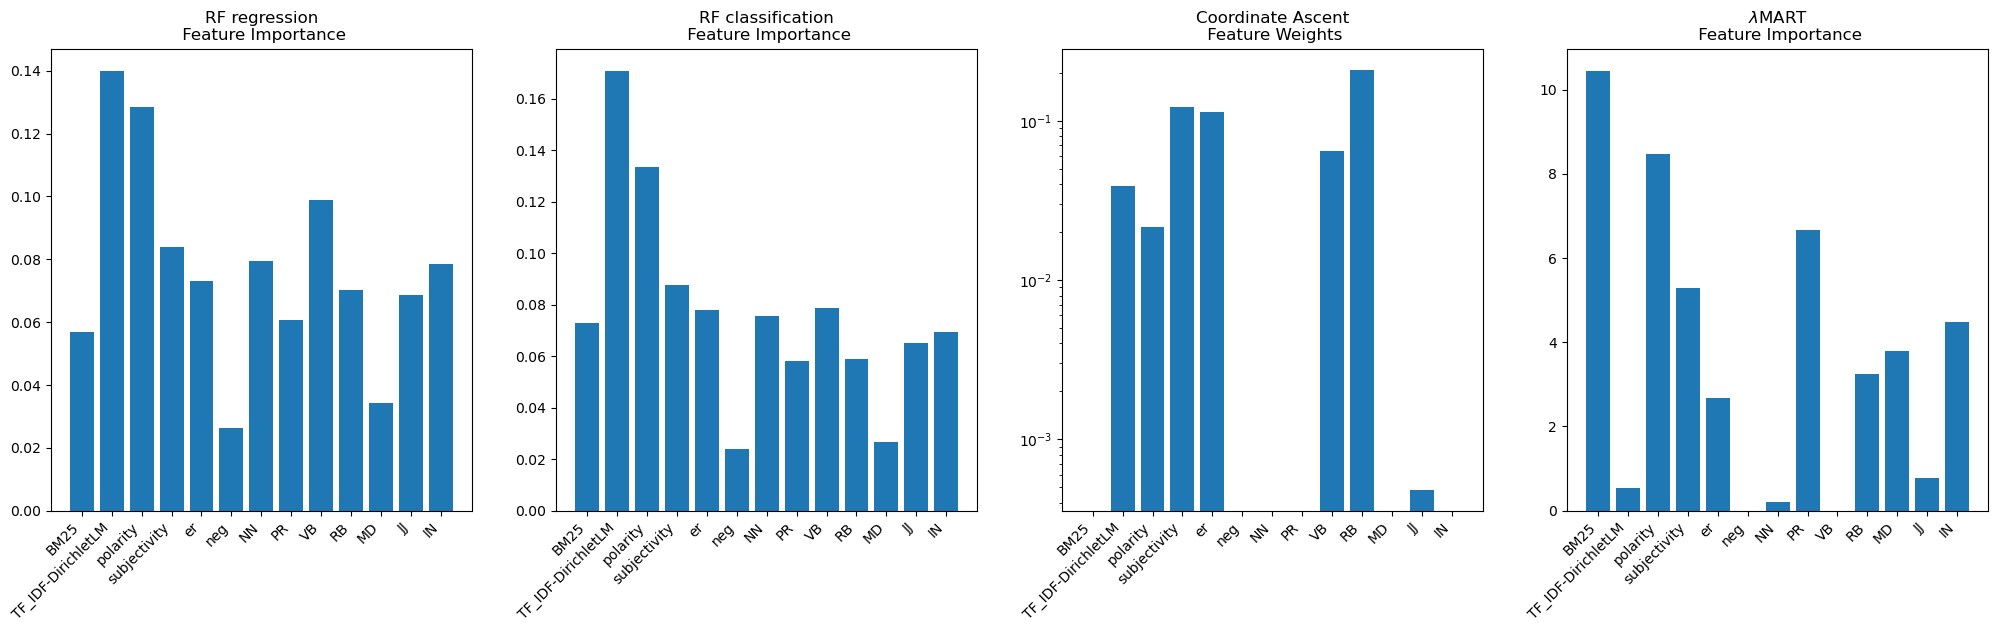

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax3, ax1, ax2) = plt.subplots(1, 4, figsize=(25, 6))


ax0.bar(np.arange(len(fnames)), rf.feature_importances_)
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("RF regression\n Feature Importance")

ax3.bar(np.arange(len(fnames)), rfc.feature_importances_)
ax3.set_xticks(np.arange(len(fnames)))
ax3.set_xticklabels(fnames, rotation=45, ha='right')
ax3.set_title("RF classification\n Feature Importance")

ax1.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Coordinate Ascent\n Feature Weights")
ax1.set_yscale('log')

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

In [29]:
models = [
        bm25,
        tfidf,
        rf_pipe,
        rfc_pipe,
        ca_pipe
        ,
        lmart_x_pipe
    ]
model_names = ['BM25', 'TF-IDF', 'RF', 'RFC', 'CA', 'LGBM']

In [ ]:
savetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
res = ndcg_per_emotion_experiment(models, model_names, emotions, test_qrels, docs_df, cutoffs=[5,10,20,50,None])
res.to_csv("project_ltr_results/experiment_"+str(num_queries_per_emotion)+"_per_emotion_" + savetime + '.csv', index=False)
res